Copyright Amazon.com, Inc. or its affiliates. All Rights Reserved. SPDX-License-Identifier: Apache-2.0

# KGC 2024 MasterClass: Generating and analyzing knowledge graphs using GenAI and Neptune Analytics
# Notebook 2: Setup LlamaIndex 

This notebook creates a LlamaIndex graph store and vector store of press release data in the Neptune Analytics graph. It coexists with the organizational knowledge graph and related Comprehend extraction results. 

Here is our data model.

<img src="images/kgc_model.png">

LlamaIndex objects are colored pink. They are mostly independent of the data we loaded in the previous notebook. Their only link is that the DOCUMENT node (white box) representing a press release is linked to Chunk nodes created by the LlamaIndex vector store.

The next figure depicts our design.

<img src="images/kgc_design.png">

The LlamaIndex portion is shown in the upper third of the figure. 

To run this notebook you need a Neptune Analytics graph that is accessible from this notebook instance. You also need an S3 bucket in the same region. We will stage chunk-to-document links in that bucket to batch-load to Neptune Analytics graph. See README.md for detailed setup instructions.

## What is LlamaIndex?

LlamaIndex is a framework for RAG based LLM applications for use cases that applies LLMs on top of your private or domain-specific data. Some popular use cases include the following:

* Question-Answering Chatbots (commonly referred to as RAG systems, which stands for "Retrieval-Augmented Generation")
* Document Understanding and Extraction
* Autonomous Agents that can perform research and take actions

LlamaIndex provides an opinionated approach and tools to build these applications from ingest, to indexing, to querying, and evaluation.


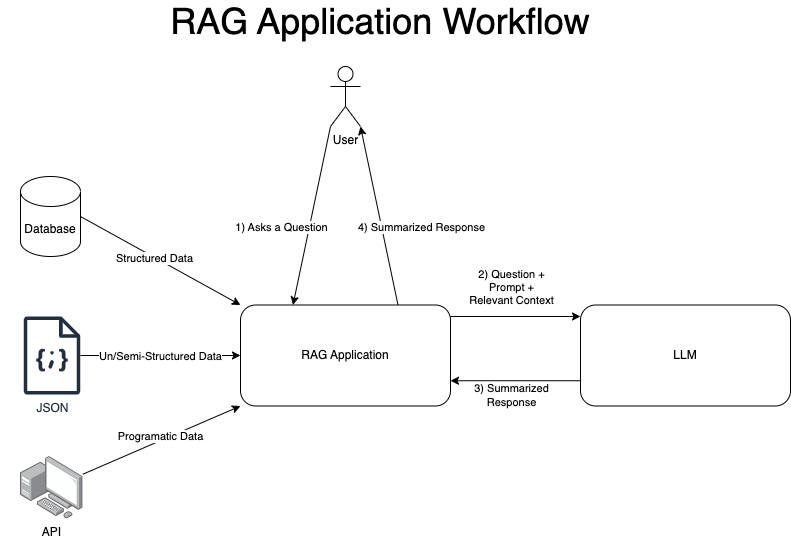

### Stages within LlamaIndex RAG applications?

There are five key stages LlamaIndex goes through when building a complete RAG application

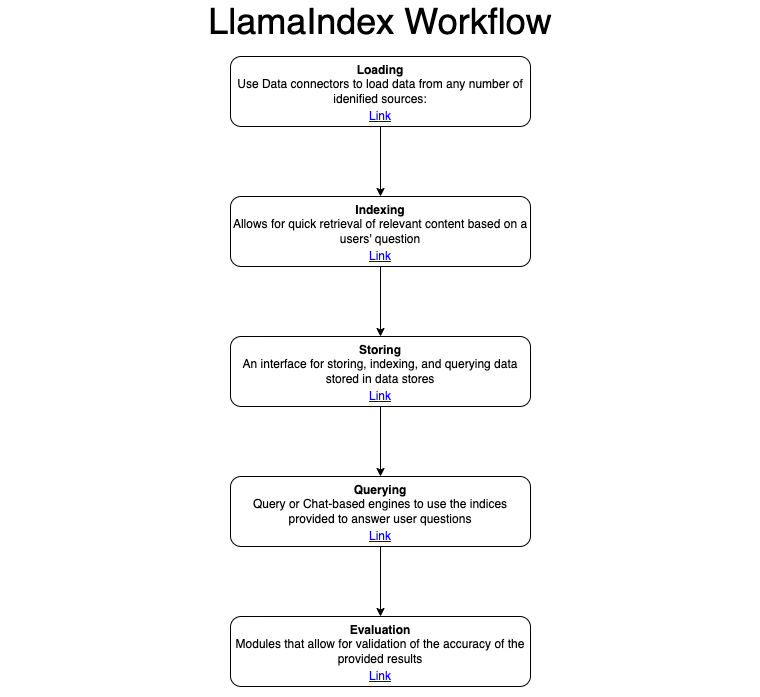

## Setup

### Install LlamaIndex libraries
We first need to ensure that we have all the LlamaIndex libraries we need installed.

In [ ]:
pip install -q llama-index llama-index-vector-stores-neptune llama-index-graph-stores-neptune  llama-index-llms-bedrock llama-index-embeddings-bedrock

### Get the Graph Configuration

In [ ]:
import graph_notebook as gn
config = gn.configuration.get_config.get_config()

region = config.aws_region
graph_identifier=config._host.split(".")[0]
graph_identifier

### Imports and Global Settings

Below we are going to be importing several of the common libraries used by LlamaIndex.  We are also setting up the LLM and Embedding Models we will use.  For this example we will use Claude V3 Sonnet as our LLM and Titan Embedding V1 to generate our embeddings, both hosted on Amazon Bedrock.

In [ ]:
from llama_index.llms.bedrock import Bedrock
from llama_index.embeddings.bedrock import BedrockEmbedding
from llama_index.core import StorageContext, VectorStoreIndex, KnowledgeGraphIndex, Settings
from llama_index.core import SimpleDirectoryReader

# define LLM
llm = Bedrock(model="anthropic.claude-3-sonnet-20240229-v1:0", 
    model_kwargs={"temperature": 0})
embed_model = BedrockEmbedding(model="amazon.titan-embed-text-v1")

# Set global LLM settings
Settings.llm = llm
Settings.embed_model = embed_model

documents = SimpleDirectoryReader(input_files = ["rawtext/c60e5356-635f-4dee-b6c9-c6e2af59c83c.txt"]).load_data()

## Loading, Indexing, and Storing

### Build LlamaIndex VectorStoreIndex

Now that we have setup all our shared dependencies, let's take a look at what it looks like to build a VectorStoreIndex over this data.

In [ ]:
from llama_index.vector_stores.neptune import NeptuneAnalyticsVectorStore

# Define Vector Store
vector_store = NeptuneAnalyticsVectorStore(graph_identifier=graph_identifier, embedding_dimension=1536)
storage_context = StorageContext.from_defaults(vector_store=vector_store)


vector_index = VectorStoreIndex.from_documents(
    documents=documents,
    storage_context=storage_context,
    include_embeddings=True,
    show_progress=True,
)


#### Examining the Workflow

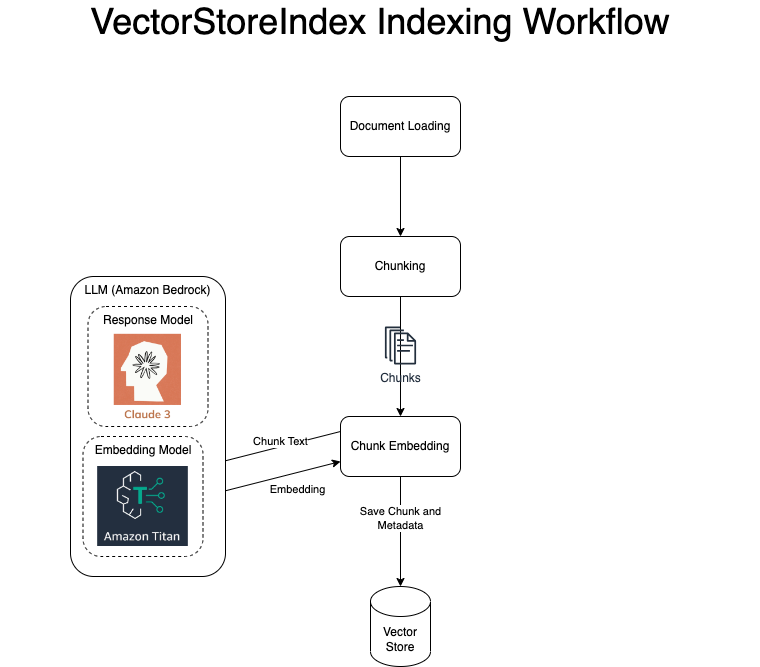

#### Examing the Vector Store

In [ ]:
%%oc

MATCH (n:Chunk) 
CALL neptune.algo.vectors.get(n)
YIELD embedding
RETURN n.file_name, id(n), n.text, embedding, n
LIMIT 1

### Build LlamaIndex KnowledgeGraphIndex

Let's compare that to what it looks like to build a KnowledgeGraphIndex over this data.

In [ ]:
from llama_index.graph_stores.neptune import NeptuneAnalyticsGraphStore

# Define Graph Store
graph_store = NeptuneAnalyticsGraphStore(graph_identifier=graph_identifier)
storage_context = StorageContext.from_defaults(graph_store=graph_store)
                                                 
kg_index = KnowledgeGraphIndex.from_documents(
     documents=documents,
     storage_context=storage_context,
     max_triplets_per_chunk=50,
     include_embeddings=True,
     show_progress=True,
)

#### Examining the Workflow

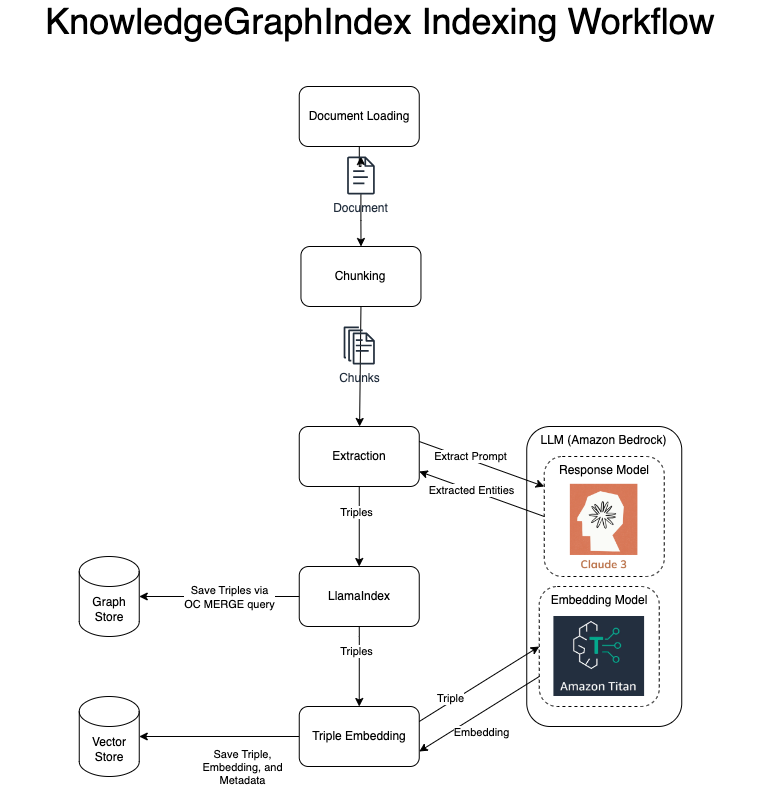

#### Examing the Graph Store

In [ ]:
%%oc -d id -l 20

MATCH triple=(s:Entity)-[p]->(o)
RETURN count(triple)


## Querying


#### Ask questions of the stores
Start with the graph store, then same query to the vector store.

You can also try the chatbot.

In [ ]:
from IPython.display import Markdown, display
query_engine = vector_index.as_query_engine()
response = query_engine.query("Does Amazon have a fulfillment center in Minnesota?")
display(Markdown(f"<b>{response}</b>"))

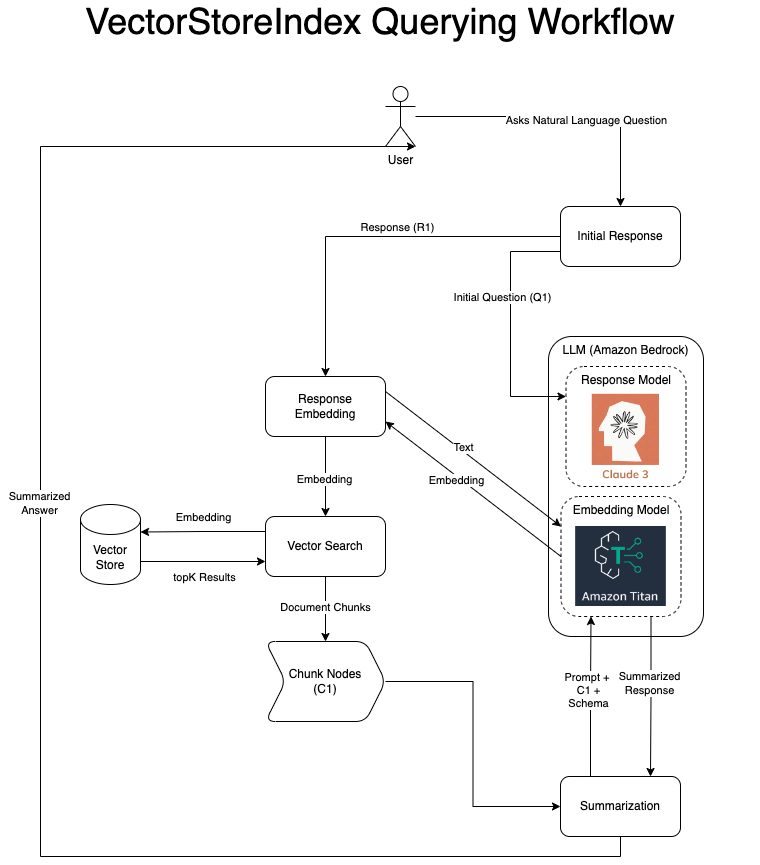

In [ ]:
from IPython.display import Markdown, display
query_engine = kg_index.as_query_engine()
response = query_engine.query("Does Amazon have a fulfillment center in Minnesota?")
display(Markdown(f"<b>{response}</b>"))

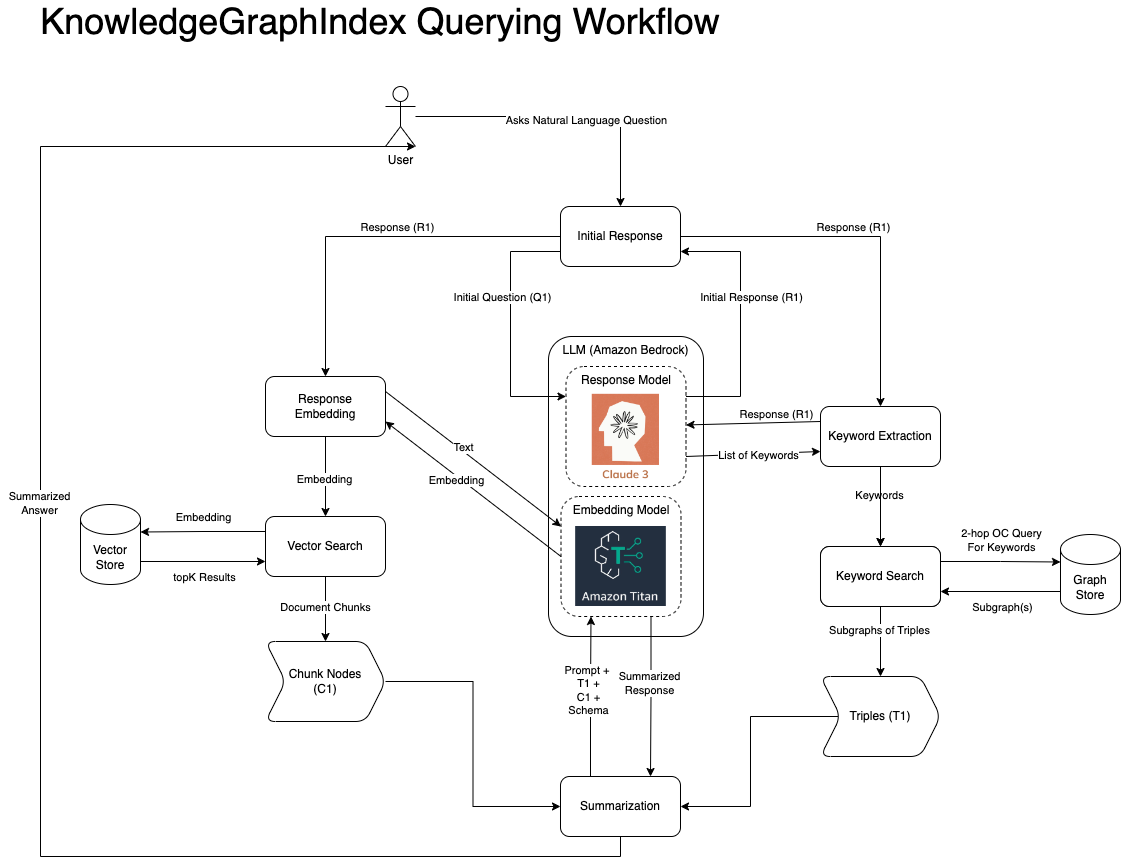

## Extras

### Get stats to see node and edge types

In [ ]:
%summary pg --detailed

### Explore the graph store
Triples

In [ ]:
%%oc

MATCH (s:Entity)-[p]->(o)
RETURN s.id, type(p), o.id
LIMIT 100

### Look at the chunks in the vector store

In [ ]:
%%oc

MATCH (n:Chunk) 
CALL neptune.algo.vectors.get(n)
YIELD embedding
RETURN n.file_name, id(n), n.text, embedding
LIMIT 20


### Do vector similarity search on vector store

In [ ]:
embedding = embed_model.get_text_embedding("kindle")
embparams={'emb': embedding}

In [ ]:
%%oc -qp embparams

WITH $emb as emb
CALL neptune.algo.vectors.topKByEmbedding(emb)
YIELD embedding, node, score
RETURN id(node), node.file_name, node.text
LIMIT 20


### Find chunks similar to a specific chunk

In [ ]:
%%oc 

MATCH(n:Chunk {`~id`: "50e02811-229c-47c1-a241-7317183ab6d1"})
CALL neptune.algo.vectors.topKByNode(n)
YIELD node, score
WHERE n.file_name <> node.file_name
RETURN score, id(n) as sourceNodeId, n.file_name as sourceNodeFile, 
id(node) as matchedNodeId, node.file_name as matchedNodeFile, 
n.text as sourceText, node.text as matchedText
ORDER BY score desc
LIMIT 20

#### Link Comprehend documents to chunks created by LlamaIndex vector store
#### Let's summarize the chunks and how they link to doc file.

In [ ]:
%%oc --store-to chunks_per_file

MATCH(c:Chunk)
RETURN id(c) as cid, c.file_name as docfile


### Build a CSV of edges linking chunks to docs

In [ ]:
!mkdir -p graphdata

In [ ]:
import csv

# write edges from chunks to document node

with open('graphdata/chunk2doc.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['~id','~from','~to','~label'])

    for res in chunks_per_file['results']:
        chunk_node_id = res['cid']
        docfile = res['docfile']
        docid = docfile.split(".")[0]
        writer.writerow([f"ce_{chunk_node_id}", chunk_node_id, docid, "belongsToDoc"])


### Copy graphdata files to S3 so we can load to Neptune

In [ ]:
S3_WORKING_BUCKET="brian-blog-s3workingbucket-stkpqblygbtg"
S3_SOURCE=f"s3://{S3_WORKING_BUCKET}/chunk2doc.csv"
S3_SOURCE


In [ ]:
%%bash -s "$S3_SOURCE"

aws s3 cp graphdata/chunk2doc.csv $1


### Batch-load to Neptune graph

In [ ]:
%%oc

CALL neptune.load({
    format: "csv", 
    source: "${S3_SOURCE}", 
    region : "${region}",
    format: "csv",
    failOnError: False,
    concurrency: 1
})



### Verify using a query

In [ ]:
%%oc

MATCH (d:DOCUMENT)<-[:belongsToDoc]-(c:Chunk)
RETURN d.title, collect(id(c))

### Finally we can combine vector similarity with observations from Comprehend!

In [ ]:
embedding = embed_model.get_text_embedding("career skills")
embparams={'emb': embedding}

In [ ]:
%%oc -qp embparams

WITH $emb as emb
CALL neptune.algo.vectors.topKByEmbedding(emb)
YIELD embedding, node, score

MATCH path=(node:Chunk)-[:belongsToDoc]->(d:DOCUMENT)-[ev]->(obs)-[role]->(ent)
RETURN path
LIMIT 200